In [2]:
from google.colab import drive

drive.mount('./drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import numpy as np

labels_train = np.fromfile('./drive/My Drive/Colab Notebooks/train_y.bin', dtype=np.uint8).astype(np.int32) - 1
labels_test = np.fromfile('./drive/My Drive/Colab Notebooks/test_y.bin', dtype=np.uint8).astype(np.int32) - 1

images_train = np.fromfile('./drive/My Drive/Colab Notebooks/train_X.bin', dtype=np.uint8)
images_train = images_train.reshape(-1, 3, 96, 96)
images_train = np.transpose(images_train, (0, 3, 2, 1)).astype(np.float)

images_test = np.fromfile('./drive/My Drive/Colab Notebooks/test_X.bin', dtype=np.uint8)
images_test = images_test.reshape(-1, 3, 96, 96)
images_test = np.transpose(images_test, (0, 3, 2, 1)).astype(np.float)


print('[*] Dataset Loaded Successfully!')

[*] Dataset Loaded Successfully!


In [0]:
def cnn_model_fn(X):
  # Input Layer
    input_layer = tf.reshape(X, [-1, 96, 96, 3])

    # Convolutional Layer 1
    convolution1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    pooling1 = tf.layers.average_pooling2d(inputs=convolution1, pool_size=[2, 2], strides=2)

    # Convolutional Layer 2
    convolution2 = tf.layers.conv2d(
        inputs=pooling1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )

    pooling2 = tf.layers.average_pooling2d(inputs=convolution2, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer 3
    convolution3 = tf.layers.conv2d(
        inputs=pooling2,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )

    pooling3 = tf.layers.average_pooling2d(inputs=convolution3, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer 4
    convolution4 = tf.layers.conv2d(
        inputs=pooling3,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )

    pooling4 = tf.layers.average_pooling2d(inputs=convolution4, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer 5
    convolution5 = tf.layers.conv2d(
        inputs=pooling4,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )

    pooling5 = tf.layers.average_pooling2d(inputs=convolution5, pool_size=[2, 2], strides=2)

    # Dense Layer
    pooling2_flat = tf.reshape(pooling5, [-1, 3 * 3 * 128])
    dense = tf.layers.dense(inputs=pooling2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=True)
    logits = tf.layers.dense(inputs=dropout, units=10)
    
#     logits = tf.argmax(logits, axis=1)
    return logits

In [0]:
def get_next_batch(data, batch_size, batch_index):
  start = batch_size * batch_index
  end = batch_size * (batch_index + 1)
  if end < len(data):
    return data[start:end]
  
  return data[start:]

In [11]:
import tensorflow as tf

X = tf.placeholder(shape=[None, 96, 96, 3], dtype=tf.float32)
Y = tf.placeholder(shape=[None,], dtype=tf.int32)

logits = cnn_model_fn(X)

loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=Y)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


epochs = 1000
batch_size = 100

average_costs = []
epochs_list = []

total_batches = int(len(images_train) / batch_size) + 1

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(epochs):
    avg_cost = 0
    for batch in range(total_batches):
      _, cost = sess.run([train_op, loss], feed_dict={X: get_next_batch(images_train, batch_size, batch), Y:get_next_batch(labels_train, batch_size, batch)})
      avg_cost += cost  
    avg_cost /= total_batches
    if epoch % 100 == 0:
      average_costs.append(avg_cost)
      epochs_list.append(epoch)
      print('[*] Epoch : ', epoch, ' Cost : ', avg_cost)
    

[*] Epoch :  0  Cost :  2.2593664562000946
[*] Epoch :  100  Cost :  0.6179173232293597
[*] Epoch :  200  Cost :  0.09727244692690232
[*] Epoch :  300  Cost :  0.028378435118379546
[*] Epoch :  400  Cost :  0.018397243634121967
[*] Epoch :  500  Cost :  0.015123375111679528
[*] Epoch :  600  Cost :  0.00511086572819919
[*] Epoch :  700  Cost :  0.005608625486310499
[*] Epoch :  800  Cost :  0.003718202179822815
[*] Epoch :  900  Cost :  0.003360977343867953


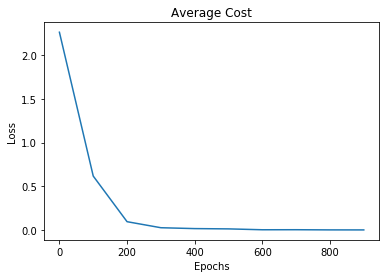

In [12]:
import matplotlib.pyplot as plt


plt.plot(epochs_list, average_costs)
plt.title('Average Cost')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
